In [1]:
%load_ext lab_black

In [40]:
import pickle
import pandas as pd
from collections import defaultdict
import re
import numpy as np
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
plt.style.use("ggplot")

In [44]:
# read scraped company dataset
companies = pd.read_csv("../data/processed/scraped_companies.csv", index_col=0)
companies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5528 entries, 0 to 5845
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   total_current_assets       2665 non-null   float64
 1   total_current_liabilities  2628 non-null   float64
 2   CIK                        5528 non-null   int64  
 3   date_filled                5528 non-null   object 
 4   url                        5528 non-null   object 
 5   current_ratio              2606 non-null   float64
 6   fiscal_year                5528 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 345.5+ KB


In [45]:
companies["CIK"] = companies["CIK"].astype("category")
companies["date_filled"] = pd.to_datetime(companies["date_filled"])

# companies.dropna(
#     subset=["total_current_assets", "total_current_liabilities"], inplace=True
# )

In [46]:
companies["fiscal_year"].sort_values(ascending=True).unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019])

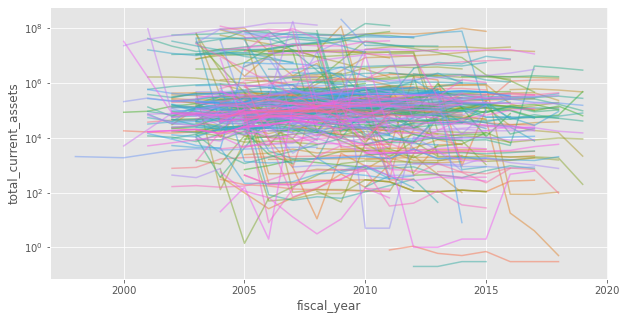

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=companies,
    x="fiscal_year",
    y="total_current_assets",
    hue="CIK",
    ax=ax,
    legend=False,
    alpha=0.5,
)
ax.set(yscale="log")
plt.show()

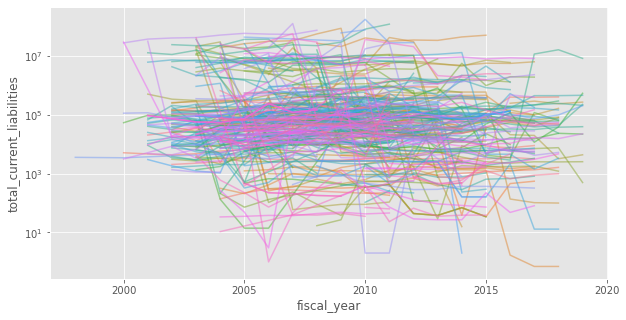

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=companies,
    x="fiscal_year",
    y="total_current_liabilities",
    hue="CIK",
    ax=ax,
    legend=False,
    alpha=0.5,
)
ax.set(yscale="log")
plt.show()

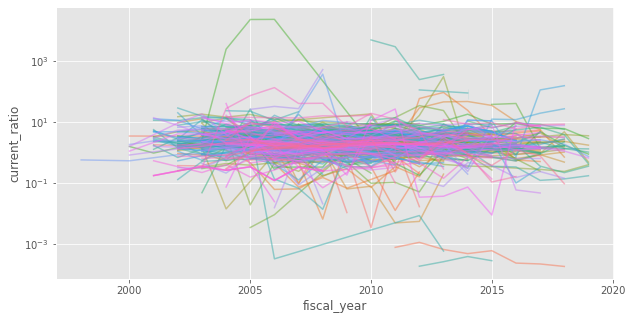

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.lineplot(
    data=companies,
    x="fiscal_year",
    y="current_ratio",
    hue="CIK",
    legend=False,
    alpha=0.5,
)
ax.set(yscale="log")
plt.show()

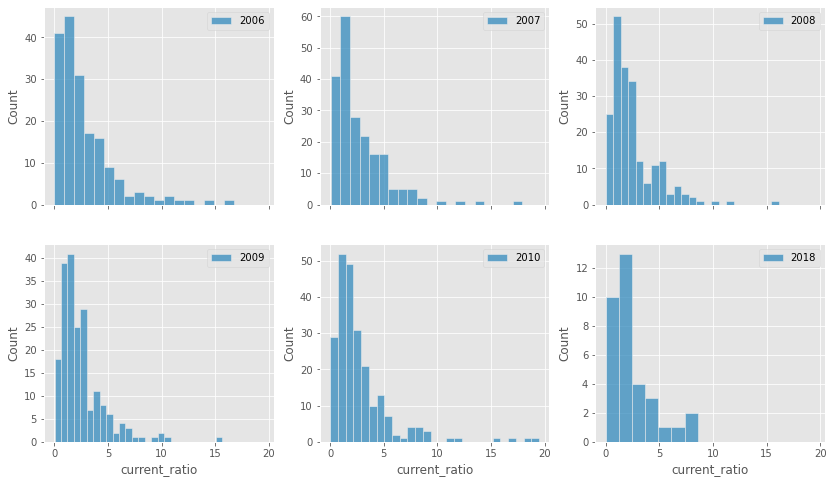

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)
years = [2006, 2007, 2008, 2009, 2010, 2018]
for year, ax in zip(years, axes.ravel()):
    df = companies[
        (companies["fiscal_year"] == year) & (companies["current_ratio"] <= 20)
    ]
    sns.histplot(data=df, x="current_ratio", ax=ax, label=f"{year}")
    ax.legend()

<AxesSubplot:xlabel='fiscal_year', ylabel='current_ratio'>

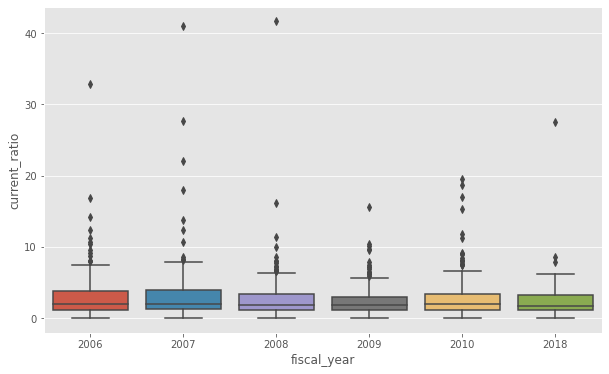

In [51]:
companies_yearsubset = companies[
    (companies["fiscal_year"].isin(years)) & (companies["current_ratio"] < 100)
]

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=companies_yearsubset, x="fiscal_year", y="current_ratio", ax=ax)

<AxesSubplot:xlabel='fiscal_year'>

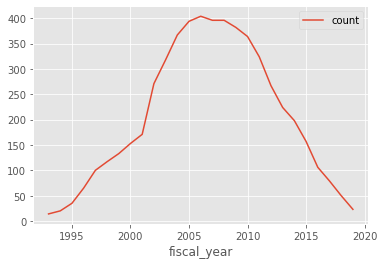

In [52]:
companies.groupby("fiscal_year").agg(count=("CIK", "count")).plot()

In [53]:
# merge with company survival dataset to get company names

fillings = pd.read_csv(
    "../data/intermediate/companies_filling_minimal.csv", index_col=0
)
fillings.head()

,Company Name,CIK,most_recent_filling
0,1 800 CONTACTS INC,1050122,2008-02-13
1,1ST STATE BANCORP INC,1074078,2008-02-13
2,24/7 REAL MEDIA INC,1062195,2007-07-12
3,3CI COMPLETE COMPLIANCE CORP,883787,2006-04-26
4,3COM CORP,738076,2011-02-14


In [54]:
companies_merged = pd.merge(
    fillings, companies, on="CIK", validate="one_to_many"
).reset_index()
companies_merged.head()

,index,Company Name,CIK,most_recent_filling,total_current_assets,total_current_liabilities,date_filled,url,current_ratio,fiscal_year
0,0,3COM CORP,738076,2011-02-14,224991.0,180273.0,2009-05-29,https://www.sec.gov/Archives/edgar/data/000073...,1.248057,2008
1,1,3COM CORP,738076,2011-02-14,809905.0,504461.0,2008-05-30,https://www.sec.gov/Archives/edgar/data/000073...,1.605486,2007
2,2,3COM CORP,738076,2011-02-14,897682.0,640068.0,2007-06-01,https://www.sec.gov/Archives/edgar/data/000073...,1.402479,2007
3,3,3COM CORP,738076,2011-02-14,1249345.0,471281.0,2006-06-02,https://www.sec.gov/Archives/edgar/data/000073...,2.650956,2006
4,4,3COM CORP,738076,2011-02-14,977509.0,309560.0,2005-06-03,https://www.sec.gov/Archives/edgar/data/000073...,3.157737,2005


In [55]:
companies_merged["date_filled"] = pd.to_datetime(companies_merged["date_filled"])
companies_merged["most_recent_filling"] = pd.to_datetime(
    companies_merged["most_recent_filling"]
)
companies_merged["CIK"] = companies_merged["CIK"].astype("category")

In [56]:
def get_fiscal_year(dt):
    if dt.month < 6:
        return dt.year - 1
    else:
        return dt.year

<AxesSubplot:>

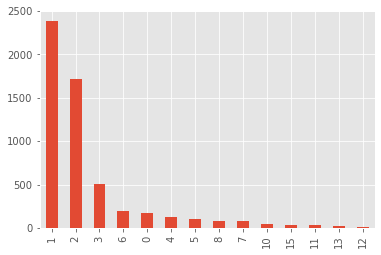

In [57]:
most_recent_dict = (
    companies_merged.groupby("CIK").max()[["date_filled"]].to_dict()["date_filled"]
)
first_dict = (
    companies_merged.groupby("CIK").min()[["date_filled"]].to_dict()["date_filled"]
)
companies_merged["most_recent_10k_filling"] = companies_merged["CIK"].apply(
    lambda x: most_recent_dict[x]
)
companies_merged["first_10k_filling"] = companies_merged["CIK"].apply(
    lambda x: first_dict[x]
)

(
    companies_merged["most_recent_filling"].dt.year
    - companies_merged["most_recent_10k_filling"].dt.year
).value_counts().plot.bar()

In [58]:
print(companies_merged.shape)
print(companies.shape)

(5528, 12)
(5528, 7)


In [59]:
# save merged dataset
companies_merged.to_csv("../data/processed/scraped_companies_merged_survival.csv")

In [60]:
companies_merged["first_10k_filling"].value_counts()

1997-12-31    382
2002-12-31    365
2004-12-31    349
1998-12-31    332
2003-12-31    308
             ... 
2004-06-30      5
2017-02-25      4
2014-12-31      4
2006-08-26      4
2004-12-29      1
Name: first_10k_filling, Length: 119, dtype: int64

In [61]:
ciks_logged_2005 = companies_merged.loc[
    companies_merged["date_filled"].dt.year == 2005, "CIK"
]
ciks = companies_merged["CIK"].unique()
print(len(ciks_logged_2005))
print(len(ciks))

389
482


In [62]:
companies_merged["duration"] = (
    companies_merged["most_recent_10k_filling"].dt.year
    - companies_merged["first_10k_filling"].dt.year
)
cik_counts = companies_merged["CIK"].value_counts().sort_index()
duration_by_cik = companies_merged.groupby("CIK").min()["duration"].sort_index()

is_continous_ciks = cik_counts - 1 - duration_by_cik == 0
continous_ciks = {cik for cik, is_cont in is_continous_ciks.iteritems() if is_cont}
len(continous_ciks)

336

In [63]:
companies_merged_continuous = companies_merged[
    companies_merged["CIK"].isin(continous_ciks)
]
len(companies_merged_continuous["CIK"].unique())

336

In [64]:
len(
    companies_merged_continuous[
        companies_merged_continuous["first_10k_filling"].dt.year <= 2005
    ]["CIK"].unique()
)

259

In [65]:
companies_merged_continuous_from2005 = companies_merged_continuous[
    companies_merged_continuous["first_10k_filling"].dt.year <= 2004
]

<AxesSubplot:xlabel='fiscal_year', ylabel='current_ratio'>

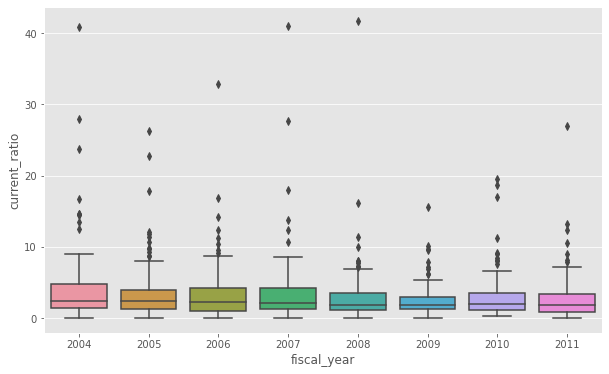

In [66]:
years = list(range(2004, 2012))

fig, ax = plt.subplots(figsize=(10, 6))
companies_yearsubset = companies_merged_continuous_from2005[
    (companies_merged_continuous_from2005["fiscal_year"].isin(years))
    & (companies_merged_continuous_from2005["current_ratio"] < 50)
]
sns.boxplot(data=companies_yearsubset, x="fiscal_year", y="current_ratio", ax=ax)

In [67]:
companies_merged_continuous_from2005.to_csv(
    "../data/processed/scraped_companies_merged_survival_continuous_from2005.csv"
)

In [68]:
companies_merged["most_recent_10k_fiscal_year"] = companies_merged[
    "most_recent_10k_filling"
].apply(lambda x: get_fiscal_year(x))

companies_merged_continuous_from2005[
    "most_recent_10k_fiscal_year"
] = companies_merged_continuous_from2005["most_recent_10k_filling"].apply(
    lambda x: get_fiscal_year(x)
)

/var/folders/57/h9v24nzx4pj9gx46p1yhvwxm0000gn/T/ipykernel_62875/3199527907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies_merged_continuous_from2005[


<AxesSubplot:>

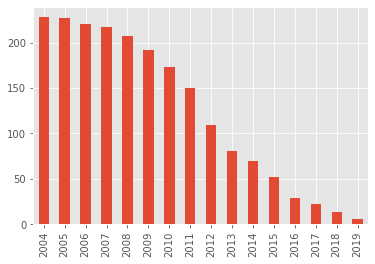

In [69]:
companies_merged_continuous_from2005.loc[
    companies_merged_continuous_from2005["fiscal_year"] >= 2004, "fiscal_year"
].value_counts().sort_index().plot.bar()

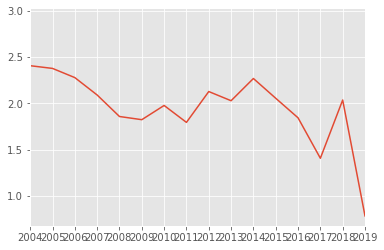

In [70]:
current_ratio_avg = companies_merged_continuous_from2005.groupby("fiscal_year").agg(
    mean_current_ratio=("current_ratio", "mean"),
    median_current_ratio=("current_ratio", "median"),
)

fig, ax = plt.subplots()
ax.plot(current_ratio_avg.index, current_ratio_avg["median_current_ratio"])
ax.set_xlim([2004, 2019])
ax.set_xticks(list(range(2004, 2020)))
plt.show()

<AxesSubplot:xlabel='fiscal_year', ylabel='current_ratio'>

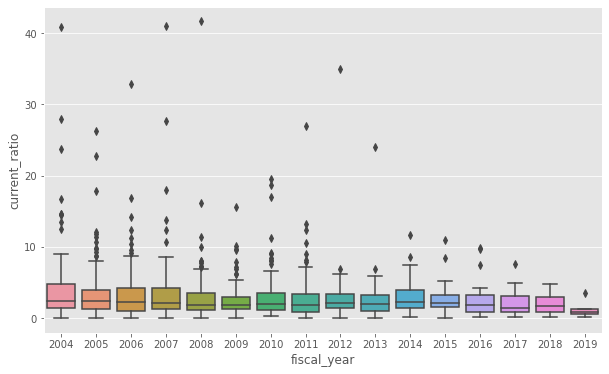

In [71]:
years = list(range(2004, 2020))

fig, ax = plt.subplots(figsize=(10, 6))
companies_yearsubset = companies_merged_continuous_from2005[
    (companies_merged_continuous_from2005["fiscal_year"].isin(years))
    & (companies_merged_continuous_from2005["current_ratio"] < 50)
]
sns.boxplot(data=companies_yearsubset, x="fiscal_year", y="current_ratio", ax=ax)

In [72]:
companies_merged_continuous_from2005.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2760 entries, 0 to 5527
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   index                        2760 non-null   int64         
 1   Company Name                 2760 non-null   object        
 2   CIK                          2760 non-null   category      
 3   most_recent_filling          2760 non-null   datetime64[ns]
 4   total_current_assets         1189 non-null   float64       
 5   total_current_liabilities    1174 non-null   float64       
 6   date_filled                  2760 non-null   datetime64[ns]
 7   url                          2760 non-null   object        
 8   current_ratio                1165 non-null   float64       
 9   fiscal_year                  2760 non-null   int64         
 10  most_recent_10k_filling      2760 non-null   datetime64[ns]
 11  first_10k_filling            2760 non-null 

In [215]:
# bootstrap for current ratio for each year to measure standard deviation

years = list(range(2004, 2020))
df = companies_merged_continuous_from2005
# df = companies_merged


def bootstrap(ser: pd.Series, n=100000) -> np.array:
    #     medians = np.zeros(n)
    #     for i in range(n):
    #         sample = ser.sample(n=len(ser), replace=True)
    #         medians[i] = sample.median()
    arr = ser.values
    arr = arr[~np.isnan(arr)]
    samples = np.random.choice(arr, size=(n, len(arr)), replace=True)
    medians = np.median(samples, axis=1)
    return medians


median_current_ratios = np.zeros(len(years))
std_current_ratios = np.zeros(len(years))
for i, year in enumerate(years):
    current_ratio_year = df[df["fiscal_year"] == year]["current_ratio"]
    medians = bootstrap(current_ratio_year)
    median_current_ratios[i] = medians.mean()
    std_current_ratios[i] = medians.std()

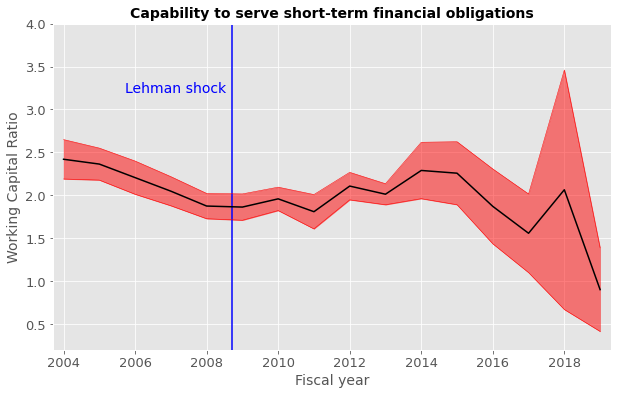

In [195]:
# lehman brothers
lehman_date = datetime.date(year=2008, month=9, day=15)
x_lehman = (
    lehman_date.year
    + (lehman_date - datetime.date(year=lehman_date.year, month=1, day=1)).days / 365
)

fig, ax = plt.subplots(figsize=(10, 6))
# ax.errorbar(years, median_current_ratios, yerr=std_current_ratios)
y = median_current_ratios
y_up = median_current_ratios + std_current_ratios
y_lo = median_current_ratios - std_current_ratios
ax.fill_between(years, y_lo, y_up, alpha=0.5, color="red")
ax.plot(years, y_lo, color="red", linewidth=0.5)
ax.plot(years, y_up, color="red", linewidth=0.5)
ax.plot(years, y, color="black")
ax.set_xlim([2003.7, 2019.3])
ax.set_xticks(list(range(2004, 2020, 2)))
ax.set(
    xlabel="Fiscal year",
    ylabel="Working Capital Ratio",
)
ax.set_title("Capability to serve short-term financial obligations", fontweight="bold")
ax.set_ylim([0.2, 4])

# lehman
ax.vlines(x_lehman, *ax.get_ylim(), color="blue")
ax.text(x_lehman - 0.15, 3.2, "Lehman shock", ha="right", color="blue", fontsize=14)

# custom
plt.rc("xtick", labelsize=13)
plt.rc("ytick", labelsize=13)
plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
# plt.xticks(rotation=-45)
# ax.set_facecolor("white")

fig.savefig("../figures/current_ratio.pdf", bbox_inches="tight")
plt.show()

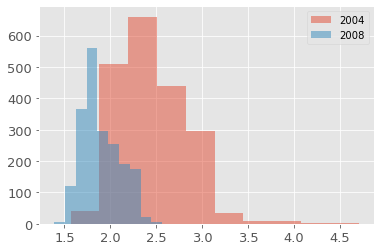

In [219]:
current_ratio_2008 = df[df["fiscal_year"] == 2008]["current_ratio"]
current_ratio_2004 = df[df["fiscal_year"] == 2004]["current_ratio"]
medians_2004 = bootstrap(current_ratio_2004, 2000)
medians_2008 = bootstrap(current_ratio_2008, 2000)

fig, ax = plt.subplots()
ax.hist(medians_2004, alpha=0.5, label="2004")
ax.hist(medians_2008, alpha=0.5, label="2008")
ax.legend()
plt.show()

In [217]:
import scipy as sc

print(sc.stats.shapiro(medians_2004))
print(sc.stats.shapiro(medians_2008))

ShapiroResult(statistic=0.9560819864273071, pvalue=2.263134597104199e-36)
ShapiroResult(statistic=0.9682122468948364, pvalue=7.038460504644578e-32)


In [220]:
sc.stats.kruskal(medians_2004, medians_2008)

KruskalResult(statistic=2220.515857863563, pvalue=0.0)

In [238]:
df_2004 = df[df["fiscal_year"] == 2004]
df_2004["above_median_ratio"] = df_2004["current_ratio"] >= median_current_ratios[0]
ciks_above = set(df_2004[df_2004["above_median_ratio"]]["CIK"])
ciks_below = set(df_2004[~df_2004["above_median_ratio"]]["CIK"])

/var/folders/57/h9v24nzx4pj9gx46p1yhvwxm0000gn/T/ipykernel_62875/2823339584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2004["above_median_ratio"] = df_2004["current_ratio"] >= median_current_ratios[0]


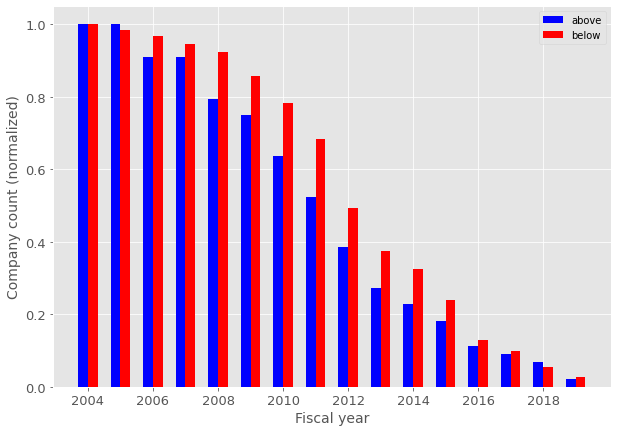

In [256]:
cik_counts_above = (
    df.loc[(df["fiscal_year"] >= 2004) & (df["CIK"].isin(ciks_above))]["fiscal_year"]
    .sort_index()
    .value_counts()
)
cik_counts_below = (
    df.loc[(df["fiscal_year"] >= 2004) & (df["CIK"].isin(ciks_below))]["fiscal_year"]
    .sort_index()
    .value_counts()
)

cik_counts_above /= cik_counts_above.iloc[0]
cik_counts_below /= cik_counts_below.iloc[0]

fig, ax = plt.subplots(figsize=(10, 7))
ax.bar(
    cik_counts_above.index - 0.15,
    cik_counts_above.values,
    label="above",
    color="blue",
    width=0.3,
)
ax.bar(
    cik_counts_below.index + 0.15,
    cik_counts_below.values,
    label="below",
    width=0.3,
    color="red",
)
ax.set_xticks(list(range(2004, 2020, 2)))
ax.set(xlabel="Fiscal year", ylabel="Company count (normalized)")
ax.legend()
plt.show()

/var/folders/57/h9v24nzx4pj9gx46p1yhvwxm0000gn/T/ipykernel_62875/3602767427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2004["duration_from_2004"] = df_2004["most_recent_10k_fiscal_year"] - 2004


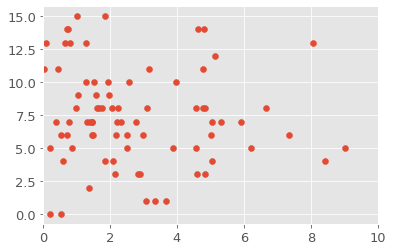

In [262]:
fig, ax = plt.subplots()
df_2004["duration_from_2004"] = df_2004["most_recent_10k_fiscal_year"] - 2004
ax.scatter(df_2004["current_ratio"], df_2004["duration_from_2004"])
ax.set_xlim([0, 10])
plt.show()

In [264]:
df_2004.loc[
    df_2004["current_ratio"] < 10, ["current_ratio", "duration_from_2004"]
].corr()

,current_ratio,duration_from_2004
current_ratio,1.000000,-0.102948
duration_from_2004,-0.102948,1.000000
